In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.tools.eval_measures import mse, rmse, rmspe 
from xgboost import XGBRegressor    
from sklearn.model_selection import cross_val_score
import seaborn as sns

sns.set_style('whitegrid')

pd.options.mode.copy_on_write=True

# Downloading the data

In [5]:
#loading the data
#years 2020-2022 are called train
#year 2023 is called test





#2023 apple data
apple_test=pd.read_csv('apple_2023_masked.csv', index_col=0) #missing_indices for test year [29, 60, 95, 124, 159, 190, 219] 
apple_test.index=apple_test.index.astype('datetime64[ns, America/New_York]')


#list of tickers
tickers_list=['AAPL', 'NVDA', 'MSFT', 'TSM', 'META', 'GOOG',]

tk_dict={}
for t in tickers_list:
    tk_dict[t]=yf.Ticker(t)

#getting data for companies ['NVDA', 'MSFT', 'TSM', 'META', 'GOOG',]

#2020-2022 data
train_df_dict={}
for t in tickers_list[1:]:
    train_df_dict[t]=tk_dict[t].history(start='2020-01-01', end='2022-12-31', interval="1d")[['Close']]

#2023 data
test_df_dict={}
for t in tickers_list[1:]:
    test_df_dict[t]=tk_dict[t].history(start='2023-01-01', end='2023-12-31', interval="1d")[['Close']]


#getting apple data for 2020-2022 as a separate table for convenience
appl=yf.Ticker("AAPL")
nvda=yf.Ticker("NVDA")
apple_close_train=appl.history(start='2020-01-01', end='2022-12-31', interval="1d")[['Close']]
nvidia_close_train=nvda.history(start='2020-01-01', end='2022-12-31', interval="1d")[['Close']]

stocks_nvidia_test=nvda.history(start='2023-01-01', end='2023-12-31', interval="1d")






In [6]:
#generating lists of indices to remove from 2020-2022 timeseries data
max_interval=5
intervals=[i for i in range(1,max_interval+1)]
n_rows=len(apple_close_train)
np.random.seed(150)
missing_indices=np.sort(np.random.randint(20, n_rows-20, size=30))
bins=np.digitize(missing_indices, bins=list(range(0, n_rows-max_interval+1, 25)))

curr_index=0
missing_indices_cleaned=[missing_indices[curr_index]]

for i,bin in enumerate(bins):
    if(bins[i]!=bins[curr_index]):
        curr_index=i
        missing_indices_cleaned.append(missing_indices[curr_index])


indices_to_mask= [np.ravel(np.array([list(range(i,i+interval)) for i in missing_indices_cleaned])) for interval in intervals]

#adding missing day columns to apple closing data 2020-2022
for i in range(max_interval):
    apple_close_train[f'{i+1}day']=apple_close_train.Close
    apple_close_train.iloc[indices_to_mask[i], i+1]=np.NaN


display(apple_close_train.head())

,Close,1day,2day,3day,4day,5day
Date,,,,,,
2020-01-02 00:00:00-05:00,72.960472,72.960472,72.960472,72.960472,72.960472,72.960472
2020-01-03 00:00:00-05:00,72.251144,72.251144,72.251144,72.251144,72.251144,72.251144
2020-01-06 00:00:00-05:00,72.826843,72.826843,72.826843,72.826843,72.826843,72.826843
2020-01-07 00:00:00-05:00,72.484352,72.484352,72.484352,72.484352,72.484352,72.484352
2020-01-08 00:00:00-05:00,73.650337,73.650337,73.650337,73.650337,73.650337,73.650337


# Baseline model - linear interpolation

baseline dataframe contains interpolated values

In [7]:
baseline=apple_close_train[['Close']].copy()
for i in range(max_interval):
    baseline[f'{i+1}day']=apple_close_train[f'{i+1}day'].interpolate(method='linear')

baseline.head(5)

,Close,1day,2day,3day,4day,5day
Date,,,,,,
2020-01-02 00:00:00-05:00,72.960472,72.960472,72.960472,72.960472,72.960472,72.960472
2020-01-03 00:00:00-05:00,72.251144,72.251144,72.251144,72.251144,72.251144,72.251144
2020-01-06 00:00:00-05:00,72.826843,72.826843,72.826843,72.826843,72.826843,72.826843
2020-01-07 00:00:00-05:00,72.484352,72.484352,72.484352,72.484352,72.484352,72.484352
2020-01-08 00:00:00-05:00,73.650337,73.650337,73.650337,73.650337,73.650337,73.650337


# Regession on daily return of other companies


Daily return formula:

$$DR=\frac{X_t - X_{t-1}}{X_{t-1}}.$$

Let $d_t$ be the daily return on the day $t$. Then, we can express the price $X_{t+i}$ on the day $t+i$, $i>0$, by the formula
$$X_{t+i}=X_t(d_{t+1}+1)(d_{t+2}+1)\dots(d_{t+i}+1).$$
The idea is to use the estimates of the daily returns $\^{d}_{t+i}$ in the above formula.

In [8]:
#function that does the computation of the stock price given daily return predictions
def get_pred(pred: pd.Series, apple_close_train: pd.DataFrame, missing_indices_cleaned: np.ndarray, interval: int):
    pred2=[]
    for j in missing_indices_cleaned:
        for i in range(interval):
            try:
                if i==0:
                    pred2.append(apple_close_train.loc[apple_close_train.index[j-1]].Close*(pred.loc[apple_close_train.index[j+i]]+1))
                else:
                    pred2.append(pred2[-1]*(pred.loc[apple_close_train.index[j+i]]+1))
            except:
                print((i,j))
    return pred2

# Ordinary Least Squares Regression

### Regressing on NVDIA daily returns

In this subsection, we will do a regression on NVIDIA 2020-2022 to see how this method does before applying it to a list of companies.

                            OLS Regression Results                            
Dep. Variable:                   5day   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     748.1
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          1.22e-109
Time:                        02:38:23   Log-Likelihood:                 1742.5
No. Observations:                 641   AIC:                            -3481.
Df Residuals:                     639   BIC:                            -3472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.175      0.8

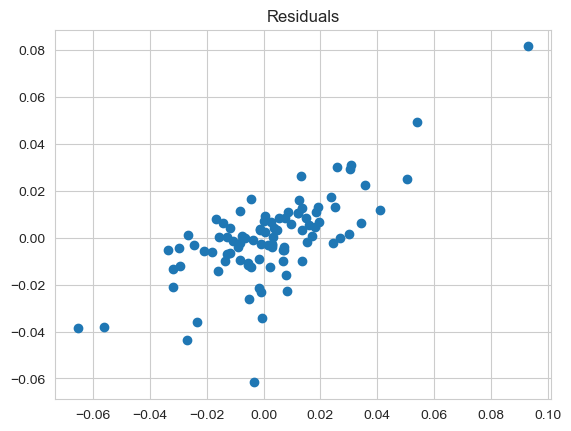

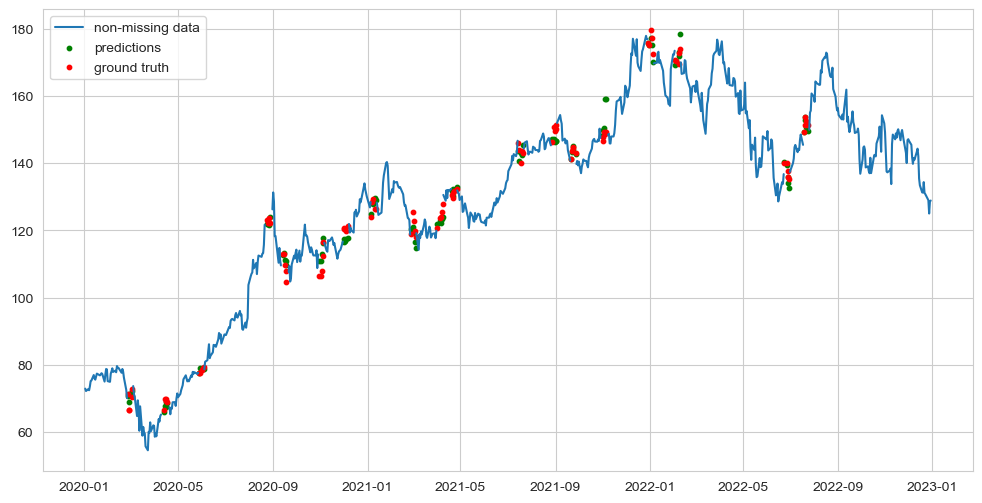

In [9]:
endog = apple_close_train['5day'].pct_change(fill_method=None)

exog = sm.add_constant(nvidia_close_train.Close.pct_change(fill_method=None))
lr=sm.OLS(endog, exog , missing='drop').fit()
print(lr.summary())

pred=lr.predict(sm.add_constant(nvidia_close_train.Close.pct_change(fill_method=None).iloc[indices_to_mask[4]]))
ground_truth=apple_close_train.Close.pct_change(fill_method=None).iloc[indices_to_mask[4]]


pred2=[]
for i in range(max_interval):
    pred2.append(get_pred(pred, apple_close_train, missing_indices_cleaned, i+1))

residuals=ground_truth-pred

#plotting the residuals
plt.scatter( x=ground_truth, y=residuals)
plt.title('Residuals')
plt.show()

#plotting the result of the prediction
fig, ax=plt.subplots(figsize=(12,6))
plt.plot(apple_close_train['5day'], label='non-missing data')
plt.scatter(apple_close_train.iloc[indices_to_mask[4]].index, pred2[4], s=10, c='g', marker='o', label='predictions')
plt.scatter(apple_close_train.iloc[indices_to_mask[4]].index, apple_close_train.iloc[indices_to_mask[4]].Close, s=10, c='r', label='ground truth' )
ax.legend()
plt.show()

## XGBoost regression

We also see how XGBoost regression does.

cv mse score of the daily return prediction 0.016456371367659723


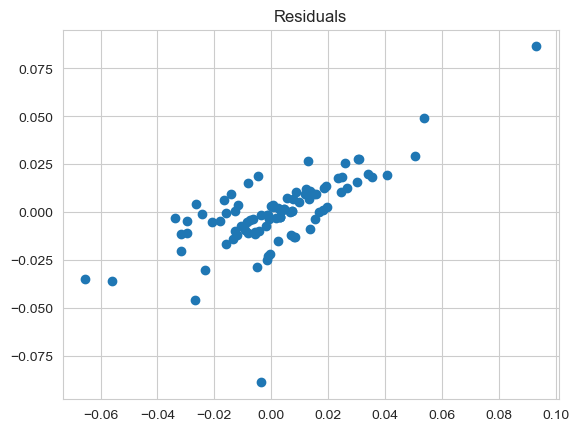

In [10]:
xgbr=XGBRegressor(n_estimators = 500,
                                  max_depth = 1,
                                  learning_rate = .1)
y=apple_close_train['5day'].pct_change(fill_method=None).dropna()
X=nvidia_close_train.Close.pct_change(fill_method=None).loc[y.index]


cv_score=cross_val_score(xgbr, X.values.reshape(-1,1),y.values.reshape(-1,1), cv=5, scoring='neg_root_mean_squared_error')
print(f'cv mse score of the daily return prediction {-cv_score.mean()}')

xgbr.fit(X.values.reshape(-1,1),y.values.reshape(-1,1))
pred=xgbr.predict(nvidia_close_train.Close.pct_change(fill_method=None).iloc[indices_to_mask[4]].values.reshape(-1,1))
pred=pd.Series(data=pred, index= nvidia_close_train.index[indices_to_mask[4]])

pred_xgbr=[]
for i in range(max_interval):
    pred_xgbr.append(get_pred(pred, apple_close_train, missing_indices_cleaned, i+1))

ground_truth=apple_close_train.Close.pct_change(fill_method=None).iloc[indices_to_mask[4]]
residuals=ground_truth-pred
plt.scatter( x=ground_truth, y=residuals)
plt.title('Residuals')
plt.show()


In [11]:
#MSE scores table

scores=pd.DataFrame({'LinearInterp': (np.zeros(5)).fill(np.NaN), 'OLS_NVDA': (np.zeros(5)).fill(np.NaN), 'XGBoostRegr_NVDA': (np.zeros(5)).fill(np.NaN)}, index=['1day', '2day', '3day', '4day', '5day'])
for i in range(max_interval):
   scores.loc[f'{i+1}day', 'LinearInterp']=mse(baseline[f'{1+i}day'].iloc[indices_to_mask[i]], baseline['Close'].iloc[indices_to_mask[i]])
   scores.loc[f'{i+1}day', 'OLS_NVDA']=mse(apple_close_train.iloc[indices_to_mask[i]].Close, pred2[i])
   scores.loc[f'{i+1}day', 'XGBoostRegr_NVDA']=mse(apple_close_train.iloc[indices_to_mask[i]].Close, pred_xgbr[i])

scores

,LinearInterp,OLS_NVDA,XGBoostRegr_NVDA
1day,3.481804,2.610946,2.908563
2day,4.770091,3.855762,4.224537
3day,7.100383,4.623535,4.640225
4day,8.217372,6.117014,7.339978
5day,7.963601,7.427277,9.329671


### OLS on the list of companies 2020-2022

Next we evaluate how OLS model does on all other companies in our list.

In [12]:

endog = apple_close_train['5day'].pct_change(fill_method=None)

for t in tickers_list[2:]:       #'MSFT', 'TSM', 'META', 'GOOG'
   exog = sm.add_constant(train_df_dict[t].Close.pct_change(fill_method=None))
   lr=sm.OLS(endog, exog , missing='drop').fit()
   print(f'\n\nOLS summary for {t}')
   print(lr.summary())

   #ind=[t for t in range(len(apple_close_train)) if t not in indices_to_mask[4]]
   pred=lr.predict(sm.add_constant(train_df_dict[t].Close.pct_change(fill_method=None).iloc[indices_to_mask[4]]))
   pred2=[]
   for i in range(max_interval):
      pred2.append(get_pred(pred, apple_close_train, missing_indices_cleaned, i+1))
   
   scores['OLS_'+t]=np.NaN
   for i in range(max_interval):
      scores.loc[f'{i+1}day', 'OLS_'+t]=mse(apple_close_train.iloc[indices_to_mask[i]].Close, pred2[i])

scores



OLS summary for MSFT
                            OLS Regression Results                            
Dep. Variable:                   5day   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     1253.
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          9.00e-153
Time:                        02:38:25   Log-Likelihood:                 1842.0
No. Observations:                 641   AIC:                            -3680.
Df Residuals:                     639   BIC:                            -3671.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.

,LinearInterp,OLS_NVDA,XGBoostRegr_NVDA,OLS_MSFT,OLS_TSM,OLS_META,OLS_GOOG
1day,3.481804,2.610946,2.908563,3.439283,5.835753,25.881566,7.860933
2day,4.770091,3.855762,4.224537,4.010507,7.997259,27.117484,8.467675
3day,7.100383,4.623535,4.640225,5.109080,8.589893,31.126455,9.176323
4day,8.217372,6.117014,7.339978,6.115092,10.420298,36.019713,10.824267
5day,7.963601,7.427277,9.329671,7.249750,11.799843,37.721535,11.257017


We can see that in the years 2020-2022, we get the lowest MSE when regressing on NVDA and MSFT daily returns. This concides with relatively high coefficient of determination $R^2$ of these models (NVDA 0.539, MSFT 0.662), so this might be an indication to use this type of model. We, however note that GOOG also has high $R^2 = 0.552$, but does not perform as well.

# Evaluation of OLS on the 2023 data

In [13]:
#getting the masked indices list
max_interval=5
intervals=[1, 2, 3, 4, 5]
missing_indices_test=[i for i in range(len(apple_test)) if np.isnan(apple_test['1day'].iloc[i])]
indices_to_mask_test= [np.ravel(np.array([list(range(i,i+interval)) for i in missing_indices_test])) for interval in intervals]

#creating additional missing indices for model selection

n_rows=len(apple_test)
np.random.seed(101)
missing_indices=np.sort(np.random.randint(max_interval, n_rows-max_interval, size=10))
bins=np.digitize(missing_indices, bins=list(range(0, n_rows-max_interval+1, max_interval)))
curr_index=0
missing_indices_train=[missing_indices[curr_index]]

for i,bin in enumerate(bins):
    if(bins[i]!=bins[curr_index]):
        curr_index=i
        missing_indices_train.append(missing_indices[curr_index])

for i in missing_indices_train:
    for j in missing_indices_train:
        if abs(i-j)<6:
            missing_indices_train.remove(j)


indices_to_mask_train= [np.ravel(np.array([list(range(i,i+interval)) for i in missing_indices_train])) for interval in intervals]
missing_indices_train

[68, 80, 92, 142, 244]

In [14]:
def powerset(lst: list[str]):
    pws=[[]]
    for l in lst:
        pws+=[p+[l] for p in pws]
    return pws[1:]

In [15]:
#for model selection, we run on different subsets and, for each company, include a run with 5 shifts of the daily returns
ickers_list=['AAPL', 'NVDA', 'MSFT', 'TSM', 'META', 'GOOG']
endog = apple_test['5day'].pct_change(fill_method=None)
endog.iloc[indices_to_mask_train[4]]=np.NaN

scores=pd.DataFrame({"['NVDA']": (np.zeros(5)).fill(np.NaN)}, index=['1day', '2day', '3day', '4day', '5day'])
r_squared_dict={}

#subsets of companies
for t_list in powerset(tickers_list[1:]):
    exog_dict={}
    for t in t_list:
       exog_dict[t]=test_df_dict[t].Close.pct_change(fill_method=None).values 
    exog = sm.add_constant(pd.DataFrame(exog_dict, index=test_df_dict['NVDA'].index))
    lr=sm.OLS(endog, exog , missing='drop').fit()
    r_squared_dict[str(t_list)]=lr.rsquared

    pred=lr.predict(sm.add_constant(exog.iloc[indices_to_mask_train[4]]))
    pred2=[]
    for i in range(max_interval):
        pred2.append(get_pred(pred, apple_test, missing_indices_train, i+1))
   
    scores[str(t_list)]=np.NaN
    for i in range(max_interval):
        scores.loc[f'{i+1}day', str(t_list)]=mse(apple_test.iloc[indices_to_mask_train[i]].Close, pred2[i])

#different shifts for each company
for t in tickers_list[1:]:
    exog_dict={}
    for j in range(max_interval):
        exog_dict[f'{t}_{j}shift']=[np.NaN for i in range(j)]+ list(test_df_dict[t].Close.pct_change(fill_method=None).values[j:])
    exog = sm.add_constant(pd.DataFrame(exog_dict, index=test_df_dict['NVDA'].index))
    lr=sm.OLS(endog, exog , missing='drop').fit()
    r_squared_dict[f'{t}_shifts']=lr.rsquared

    pred=lr.predict(sm.add_constant(exog.iloc[indices_to_mask_train[4]]))
    pred2=[]
    for i in range(max_interval):
        pred2.append(get_pred(pred, apple_test, missing_indices_train, i+1))
   
    scores[f'{t}_shifts']=np.NaN
    for i in range(max_interval):
        scores.loc[f'{i+1}day', f'{t}_shifts']=mse(apple_test.iloc[indices_to_mask_train[i]].Close, pred2[i])

df=pd.DataFrame(data=r_squared_dict.values(), index=r_squared_dict.keys(), columns=['r_squared']).sort_values(by='r_squared',ascending=False)
display(df.head())

scores.transpose().sort_values(by='5day')


,r_squared
"['NVDA', 'MSFT', 'TSM', 'META', 'GOOG']",0.429408
"['NVDA', 'MSFT', 'META', 'GOOG']",0.420915
"['MSFT', 'TSM', 'META', 'GOOG']",0.418195
"['NVDA', 'MSFT', 'TSM', 'META']",0.414628
"['NVDA', 'TSM', 'META', 'GOOG']",0.408756


,1day,2day,3day,4day,5day
"['MSFT', 'META']",0.540332,1.829233,2.375899,2.818580,3.842025
MSFT_shifts,0.591450,2.052051,2.739580,2.939879,3.952454
['MSFT'],0.634989,2.074150,2.771707,3.060426,4.237675
"['MSFT', 'META', 'GOOG']",0.803770,2.248354,2.736406,3.113968,4.303651
META_shifts,0.486447,2.100960,2.544174,3.236818,4.309845
['META'],0.491061,2.065871,2.511708,3.233771,4.348521
"['NVDA', 'MSFT', 'META']",0.438326,2.560948,3.273912,3.690925,4.576618
"['META', 'GOOG']",0.802619,2.435550,2.788722,3.334796,4.619443
"['NVDA', 'MSFT', 'META', 'GOOG']",0.682310,2.789994,3.466127,3.884859,4.946529
"['MSFT', 'GOOG']",1.090784,2.783681,3.320638,3.582157,4.958280


In [16]:
#Final model includes MSFT and META and different shifts
exog_dict={}
endog = apple_test['5day'].pct_change(fill_method=None)
endog.iloc[indices_to_mask_train[4]]=np.NaN

for t in ['MSFT', 'META']:
    for j in range(max_interval):
        exog_dict[f'{t}_{j}shift']=[np.NaN for i in range(j)]+ list(test_df_dict[t].Close.pct_change(fill_method=None).values[j:])

exog = sm.add_constant(pd.DataFrame(exog_dict, index=test_df_dict['NVDA'].index))
lr=sm.OLS(endog, exog , missing='drop').fit()
print(f'r-squared {lr.rsquared}')

pred=lr.predict(sm.add_constant(exog.iloc[indices_to_mask_train[4]]))
pred2=[]
for i in range(max_interval):
    pred2.append(get_pred(pred, apple_test, missing_indices_train, i+1))

scores["['MSFT', 'META']_shifts"]=np.NaN
for i in range(max_interval):
    scores.loc[f'{i+1}day', "['MSFT', 'META']_shifts"]=mse(apple_test.iloc[indices_to_mask_train[i]].Close, pred2[i])

scores["['MSFT', 'META']_shifts"]

r-squared 0.37151558343468627


1day    0.509479
2day    1.829725
3day    2.370457
4day    2.747083
5day    3.680184
Name: ['MSFT', 'META']_shifts, dtype: float64

In [17]:
#testing the model

baseline_test=apple_test[['Close']].copy()
for i in range(max_interval):
    baseline_test[f'{i+1}day']=apple_test[f'{i+1}day'].interpolate(method='linear')



endog = apple_test['5day'].pct_change(fill_method=None)
exog_dict={}
for t in ['MSFT', 'META']:
    for j in range(max_interval):
        exog_dict[f'{t}_{j}shift']=[np.NaN for i in range(j)]+ list(test_df_dict[t].Close.pct_change(fill_method=None).values[j:])

exog = sm.add_constant(pd.DataFrame(exog_dict, index=test_df_dict['NVDA'].index))
lr=sm.OLS(endog, exog , missing='drop').fit()
print(f"r-squared ['MSFT', 'META']_shifts {lr.rsquared}")

pred=lr.predict(sm.add_constant(exog.iloc[indices_to_mask_test[4]]))
pred2=[]
for i in range(max_interval):
    pred2.append(get_pred(pred, apple_test, missing_indices_test, i+1))


scores_test=pd.DataFrame({'LinearInterp': (np.zeros(5)).fill(np.NaN), "OLS_['MSFT', 'META']_shifts": (np.zeros(5)).fill(np.NaN)}, index=['1day', '2day', '3day', '4day', '5day'])
for i in range(max_interval):
   scores_test.loc[f'{i+1}day', 'LinearInterp']=mse(baseline_test[f'{1+i}day'].iloc[indices_to_mask_test[i]], baseline_test['Close'].iloc[indices_to_mask_test[i]])
   scores_test.loc[f'{i+1}day', "OLS_['MSFT', 'META']_shifts"]=mse(apple_test.iloc[indices_to_mask_test[i]].Close, pred2[i])



scores_test

r-squared ['MSFT', 'META']_shifts 0.3821007236589261


,LinearInterp,"OLS_['MSFT', 'META']_shifts"
1day,0.679228,0.936198
2day,2.526317,3.286361
3day,1.875199,4.271253
4day,3.398599,4.753547
5day,3.475544,5.787583
